In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.manifold import TSNE
import os

from ai4ha.util.plot import smooth_plot

In [2]:
def last_samples(path):
    dirs = os.listdir(path)
    dirs = sorted([d for d in dirs if d.startswith("sampled_data")])
    return int(dirs[-1].split('.')[0].split('_')[-1])

---

In [3]:
from ai4ha.data.series.SleepDataset import SleepDataset
import pandas as pd

In [4]:
padding = 328
paddingl = padding // 2  #0
padalgo = 'mirror-s'

In [5]:
orig = SleepDataset(dir="EEG_Sleep-b64-AE-ExtraMAE_le2_ld6_he8_hd8_p15_m0.75_e32_mlT_nlT_pnormal-OPT-adamw-lr0.001-SCplateau-f0.1-LS-MAE",
                  dataset='train',
                  padding=padding,
                  padalgo=padalgo, norm=True)

Loading data from /home/bejar/ssdstorage/Sleep


/home/bejar/PycharmProjects/misiones/ai4ha/data/series/SleepDataset.py:27: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  dataset.append(np.swapaxes(data['x'], 1, 2))
/home/bejar/PycharmProjects/misiones/ai4ha/data/series/SleepDataset.py:28: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  labels.append(data['y'])


train
X_train shape is (137521, 1, 3328)
y_train shape is (137521,)
NClasses: 5 [0 1 2 3 4]
PAD=328 PADALGO=mirror-s NORM=True


In [6]:
odata = [d[0].squeeze() for d in orig]
sdata = np.array(odata)
datal = np.array([int(d[1]) for d in orig])

In [7]:
length = sdata.shape[1] #3000

In [9]:
model = 'EEG_Sleep-all-mirror-s328-b512-M-UNET1C-s3328-l32-1244488-r6-a1-te-positional-ce-embedding-6-DF-DDPM-t500-b-4-22-ZSNR-linear-pt-sample-OPT-adamw-lr0.0001-SCcosine-w100-LS-L2'
path = f'/home/bejar/bsc/misiones/Series/Models/TimeDiffusion/logs/{model}/logs/losslog.csv'
loss = pd.read_csv(path)
loss.tail(3)

,loss (L2)
940,3942.133067
941,3789.172124
942,3947.182682


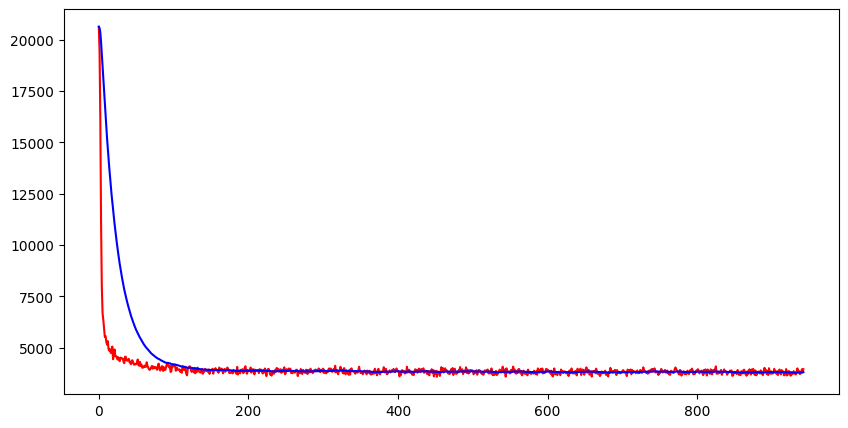

In [10]:
# loss.iloc[4:].plot(y=['MSEloss'])
smooth_plot(loss.iloc[:,0].values, 1000, 0.95)

In [11]:
# # # Final samples
# samples = np.load(
#     f'/home/bejar/bsc/misiones/Series/Models/TimeDiffusion/logs/{model}/samples/sampled_data.npz'
# )
#Generated samples
sname = 11
samples = np.load(
    f'/home/bejar/bsc/misiones/Series/Models/TimeDiffusion/logs/{model}/samples/sampled_data_{model}_{sname}.npz'
)
# samp = samples['samples'].squeeze()[:,paddingl:paddingl+length]
samp = samples['samples'].squeeze()
lab = samples['classes']
sdata.shape, samp.shape


((137521, 3328), (161792, 3328))

In [13]:
## samps = samp[lab != 7]
## labs = lab[lab != 7]
# np.savez_compressed(f'/home/bejar/bsc/misiones/Series/Models/TimeDiffusion/logs/{model}/samples/sampled_data_Sleep.npz',
#                 x=samp[:,paddingl:-paddingl], y=lab, model=model, sname=sname)

In [15]:
# fig = plt.figure(figsize=(20, 30))
ch = 0
d = 0
if '-s' in padalgo:
    vrange = range(-paddingl, length - paddingl)
else:
    vrange = range(length)
# for c in range(5):
#     for i in range(3):
#         plt.subplot(3*5, 1, c*3 + i+ 1)
#         plt.plot(vrange, sdata[datal == c][i + d], c='r')
#         plt.title(datal[datal == c][i + d])

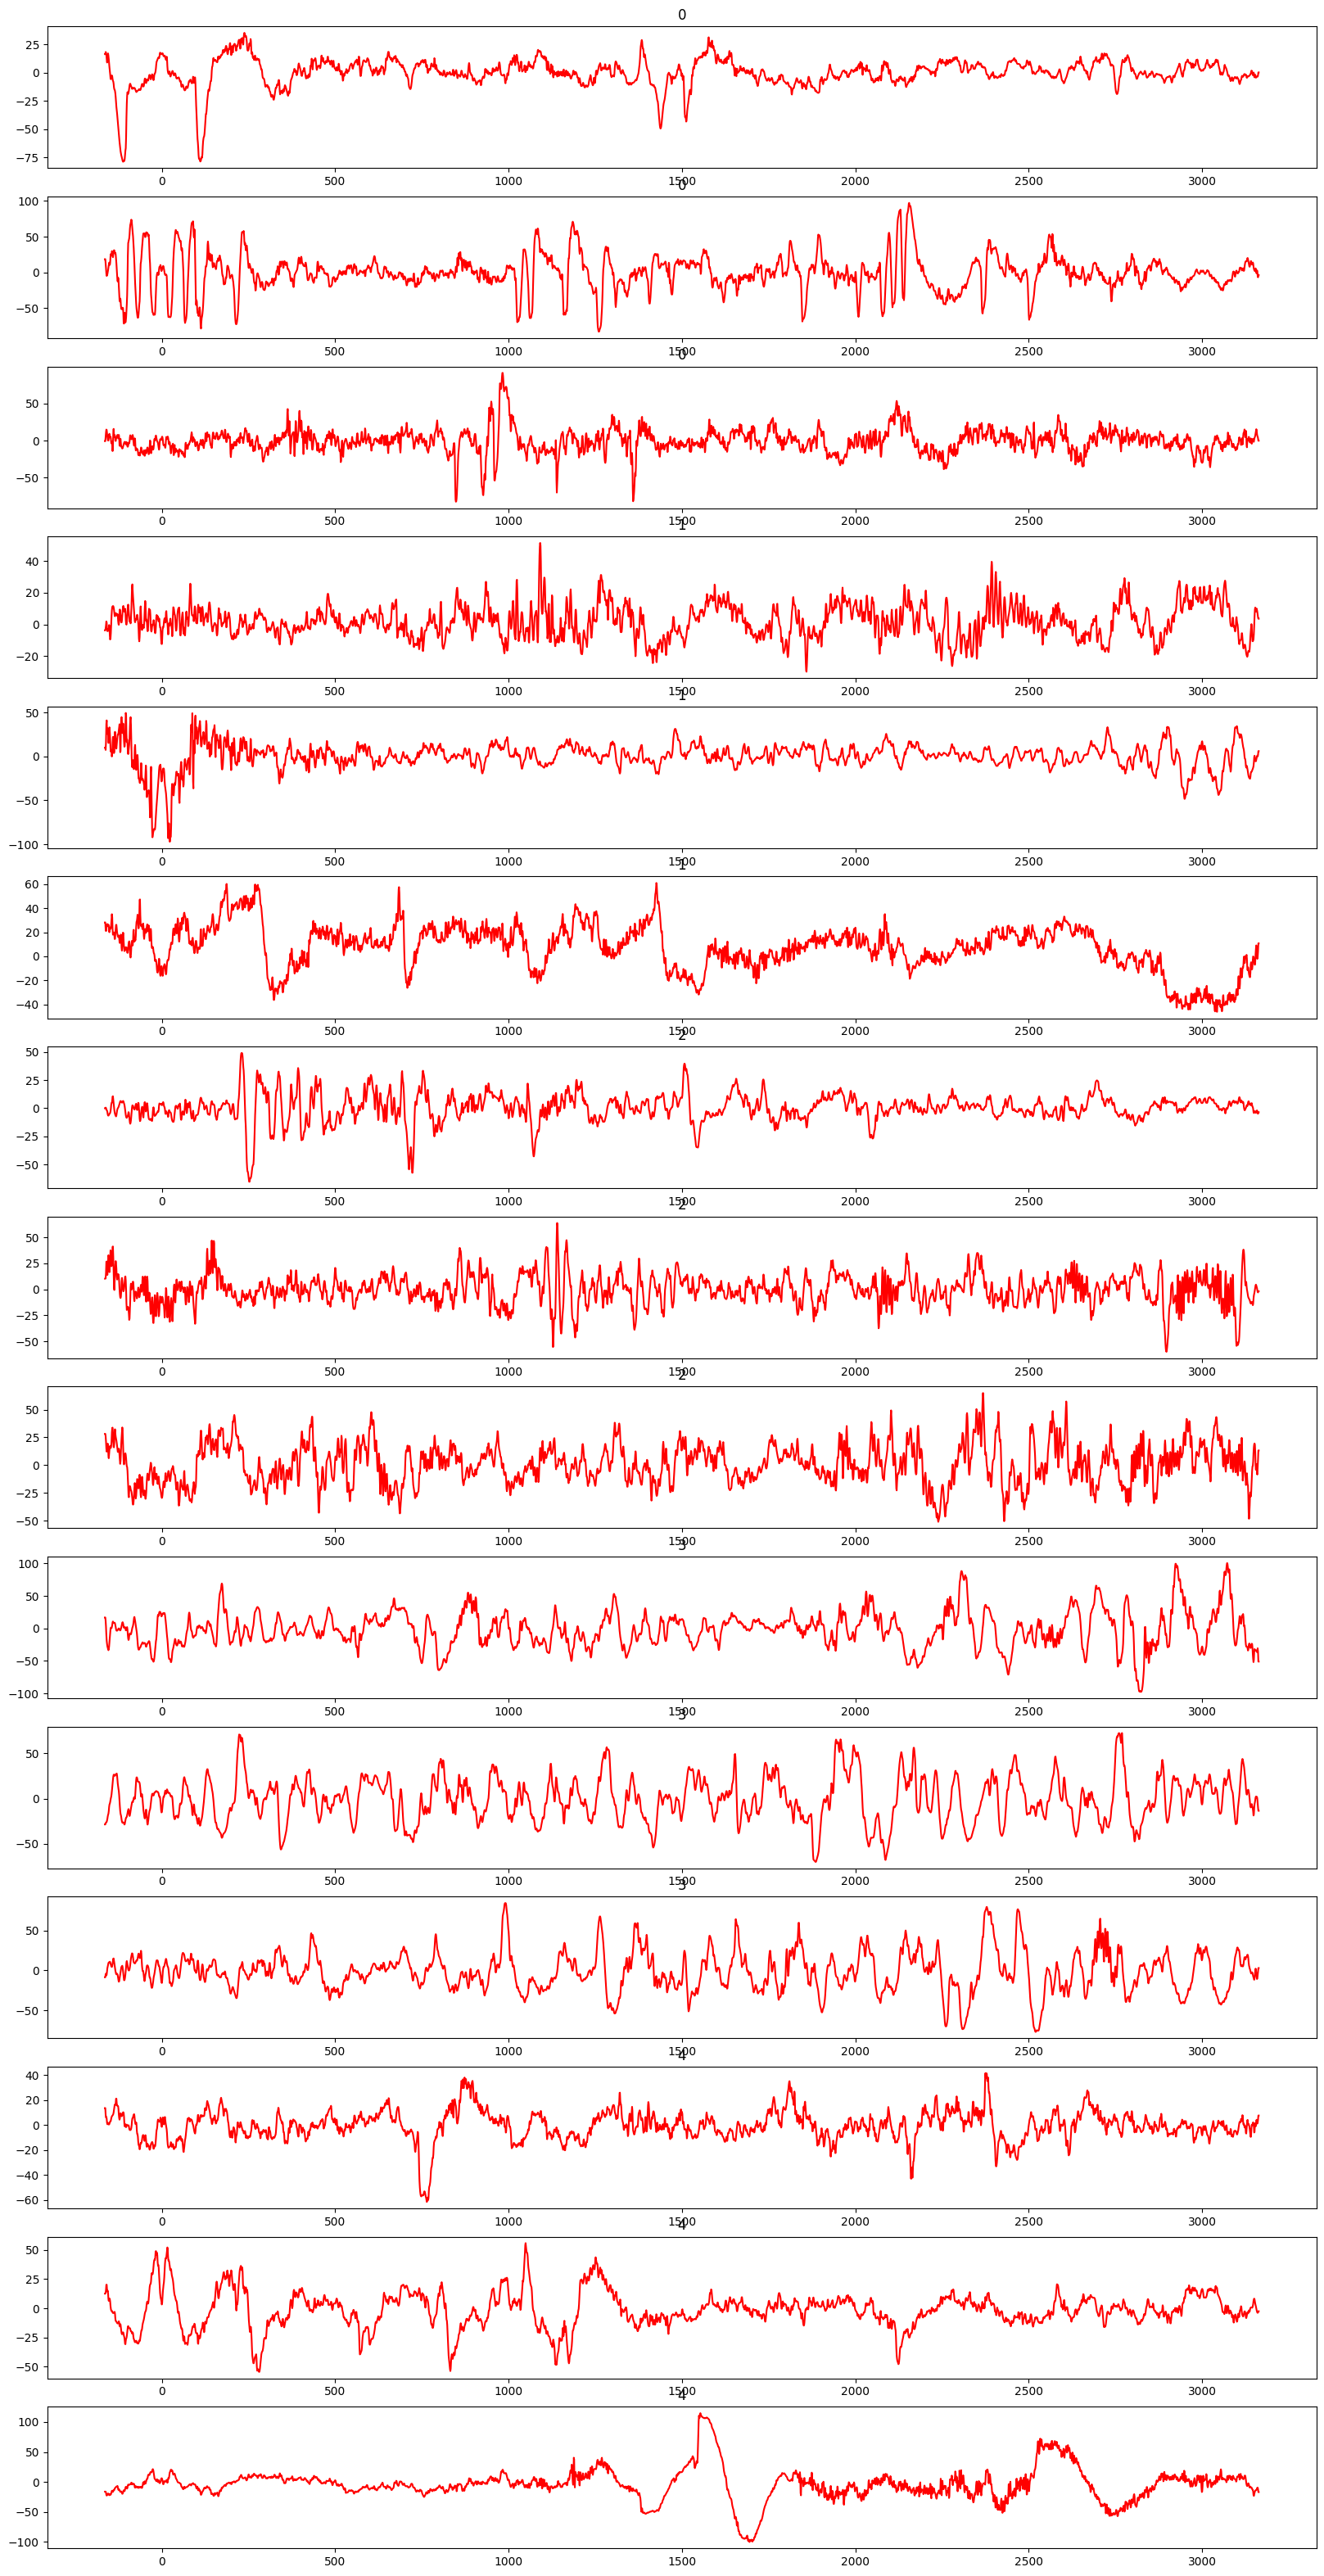

In [16]:
fig = plt.figure(figsize=(20, 40))
ch = 0
d = 0
truncate = 3000
for c in range(5):
    for i in range(3):
        plt.subplot(3 * 5, 1, c * 3 + i + 1)
        plt.plot(vrange, samp[lab == c][i + d], c='r')
        plt.title(lab[lab == c][i + d])

In [15]:
datasamp = 25000
all = np.concatenate((samp, sdata[:datasamp,:]),
                     axis=0)
tsne = TSNE(
    n_components=2,
    perplexity=10,  #max_iter=2000,
    init='random').fit_transform(all)


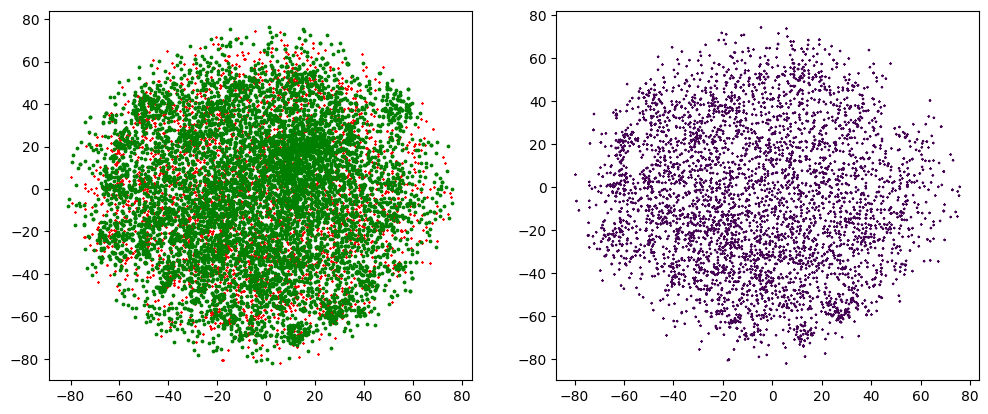

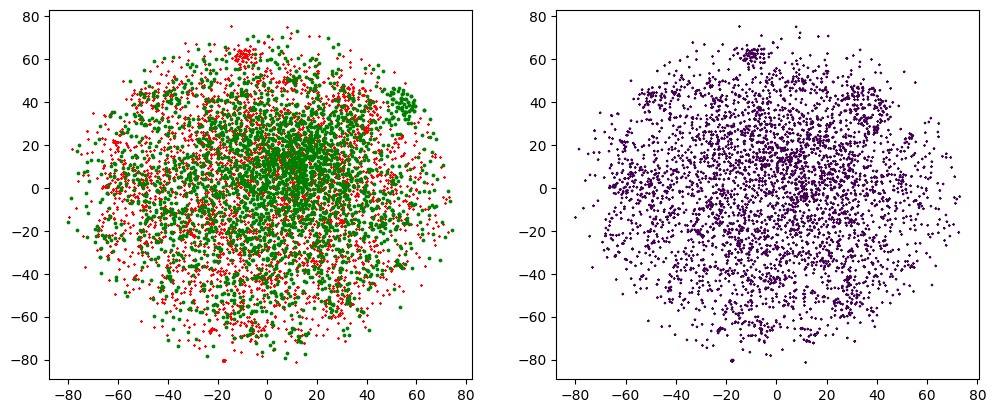

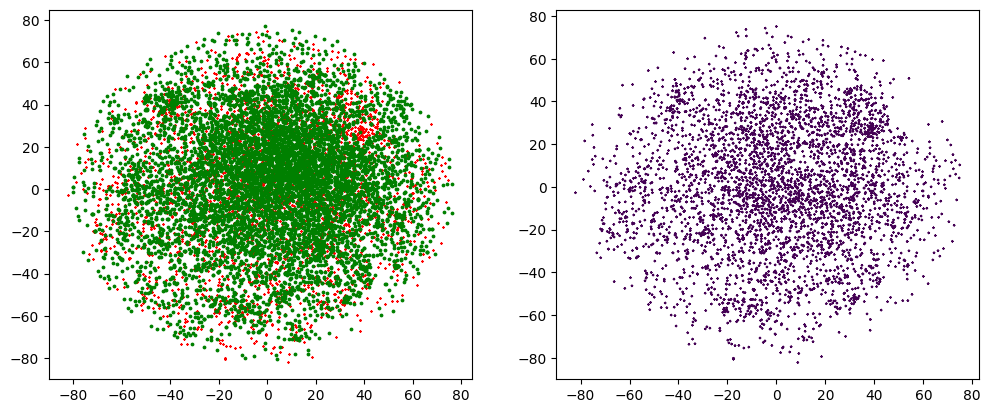

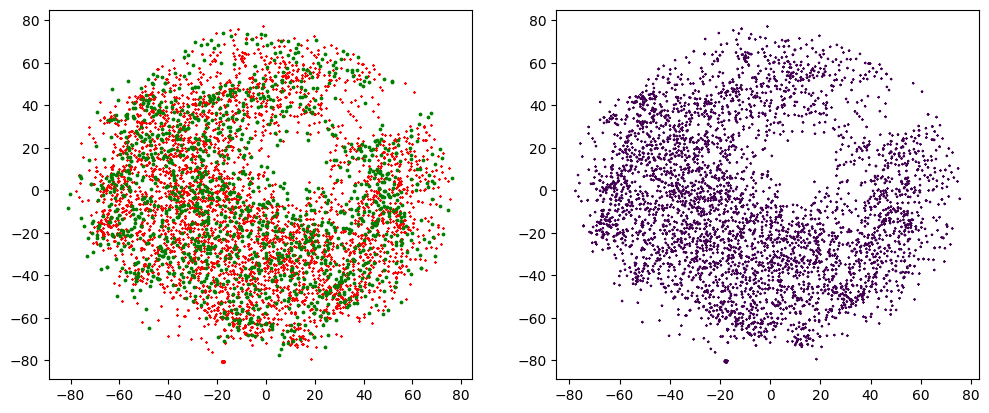

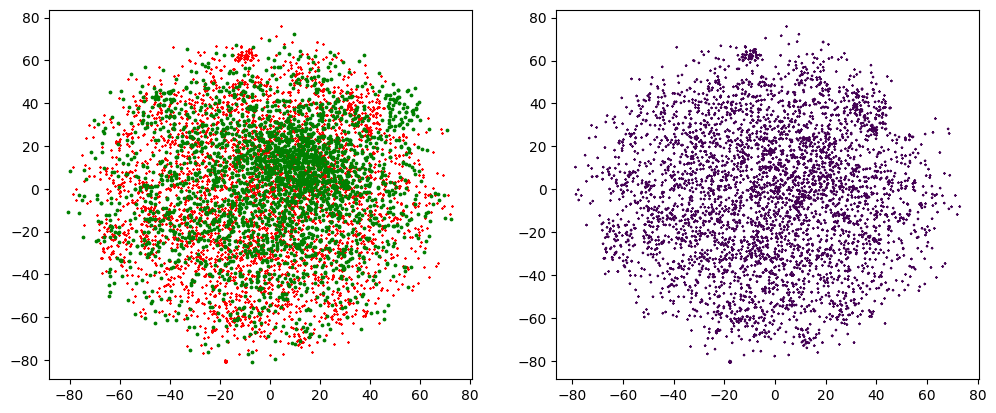

In [16]:

for lsel in range(5):
    fig = plt.figure()
    fig.set_figwidth(12)
    sp1 = fig.add_subplot(1, 2, 1)
    plt.scatter(tsne[:samp.shape[0], 0][lab == lsel],
                tsne[:samp.shape[0], 1][lab == lsel],
                c='r',
                s=1,
                marker='x')
    plt.scatter(tsne[samp.shape[0]:, 0][datal[:datasamp] == lsel],
                tsne[samp.shape[0]:, 1][datal[:datasamp] == lsel],
                c='g',
                s=3)

    # plt.xlim(-150, 150)
    # plt.ylim(-150, 150)
    sp1 = fig.add_subplot(1, 2, 2)

    plt.scatter(tsne[:samp.shape[0], 0][lab == lsel],
                tsne[:samp.shape[0], 1][lab == lsel],
                c=lab[lab == lsel],
                cmap='viridis',
                s=1,
                marker='x')
    # plt.xlim(-150, 150)
    # plt.ylim(-150, 150)


In [17]:
from numpy.fft import fft, ifft

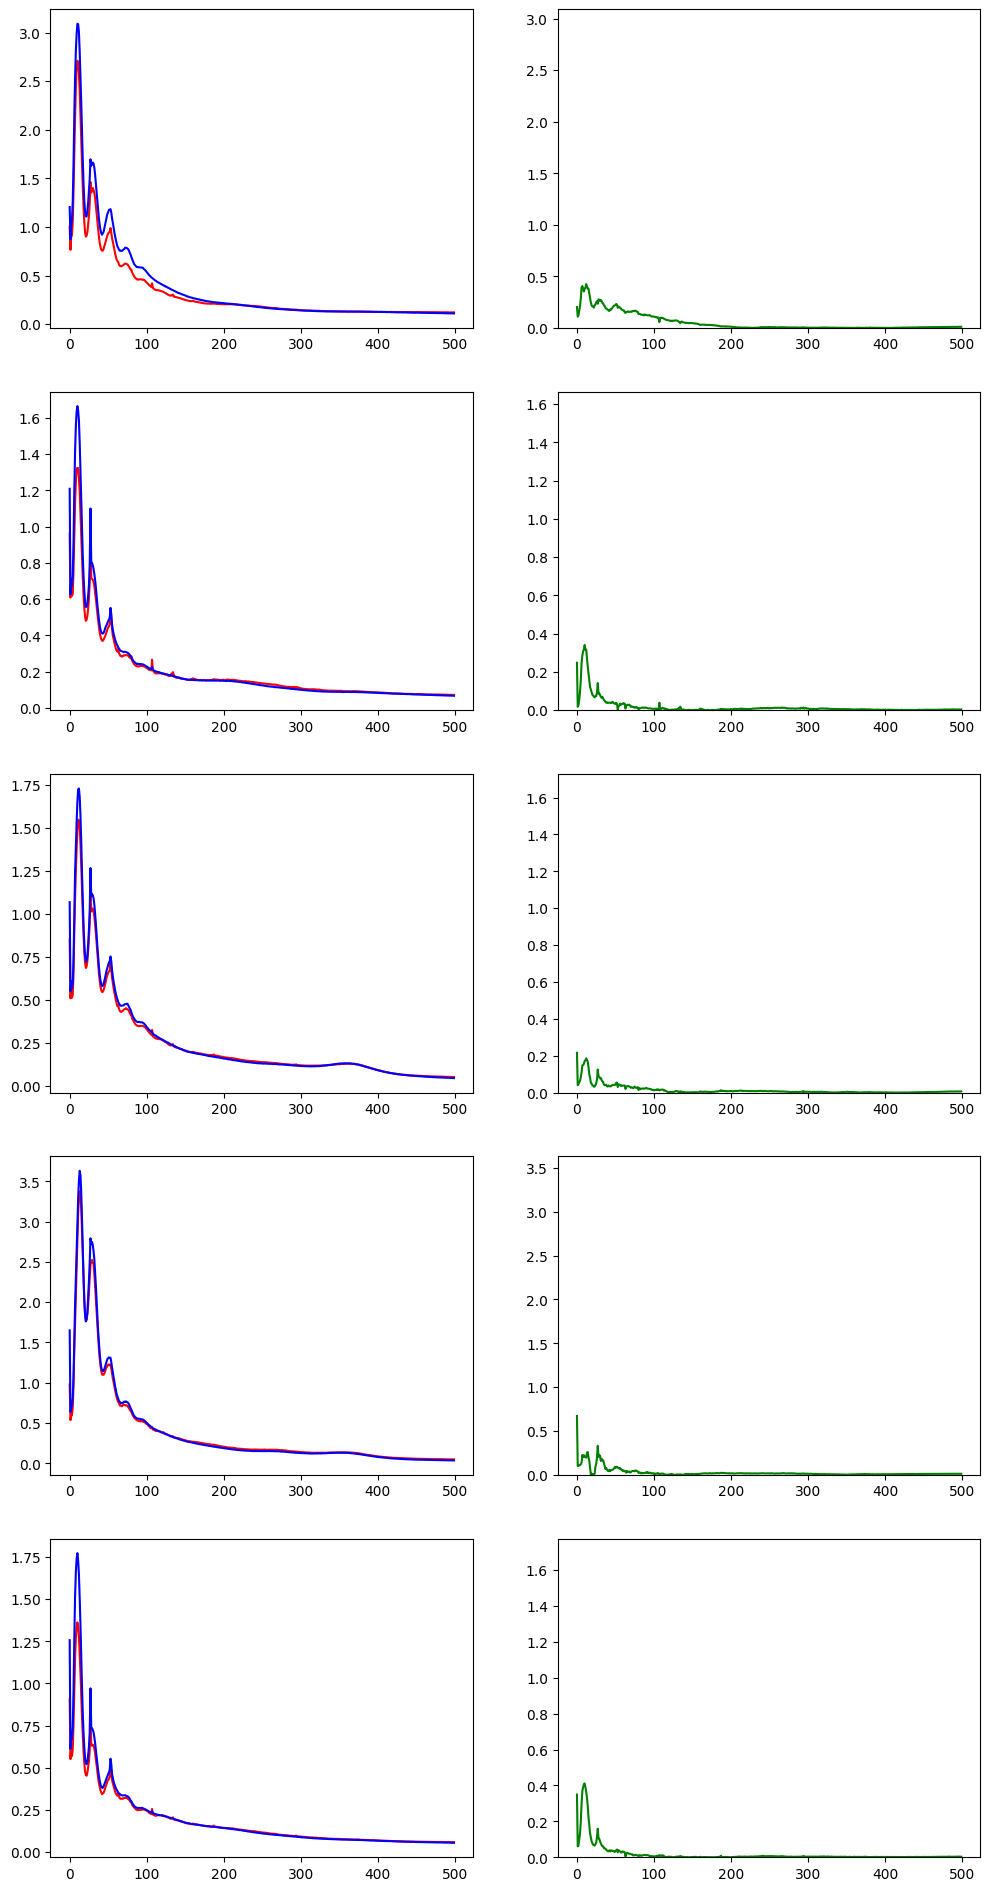

In [18]:
nfreq = 500

fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(12)
for lsel in range(5):
    if '-s' in padalgo:
        sdatas = sdata[datal == lsel][:, paddingl:length - padding]
    else:
        sdatas = sdata[datal == lsel][:, :length - padding]

    mean_freq = np.zeros((nfreq))

    for n in range(sdatas.shape[0]):
        mean_freq += np.abs(fft(
            sdatas[n][paddingl:length - padding])[:nfreq]) / sdatas.shape[1]

    mean_freq /= sdatas.shape[0]

    if '-s' in padalgo:
        samps = samp[lab == lsel][:, paddingl:length - padding]
    else:
        samps = samp[lab == lsel][:, :length - padding]

    mean_freq2 = np.zeros((nfreq))
    for n in range(samps.shape[0]):
        mean_freq2 += np.abs(fft(
            samps[n][paddingl:length - padding])[:nfreq]) / samps.shape[1]

    mean_freq2 /= samps.shape[0]


    sp1 = fig.add_subplot(5, 2, lsel * 2 + 1)
    vmax = np.max([np.max(mean_freq), np.max(mean_freq2)])

    plt.plot(mean_freq, c='r')
    plt.plot(mean_freq2, c='b')

    sp1 = fig.add_subplot(5, 2, lsel * 2 + 2)
    plt.plot(np.abs(mean_freq - mean_freq2), c='g')
    plt.ylim(0, vmax)



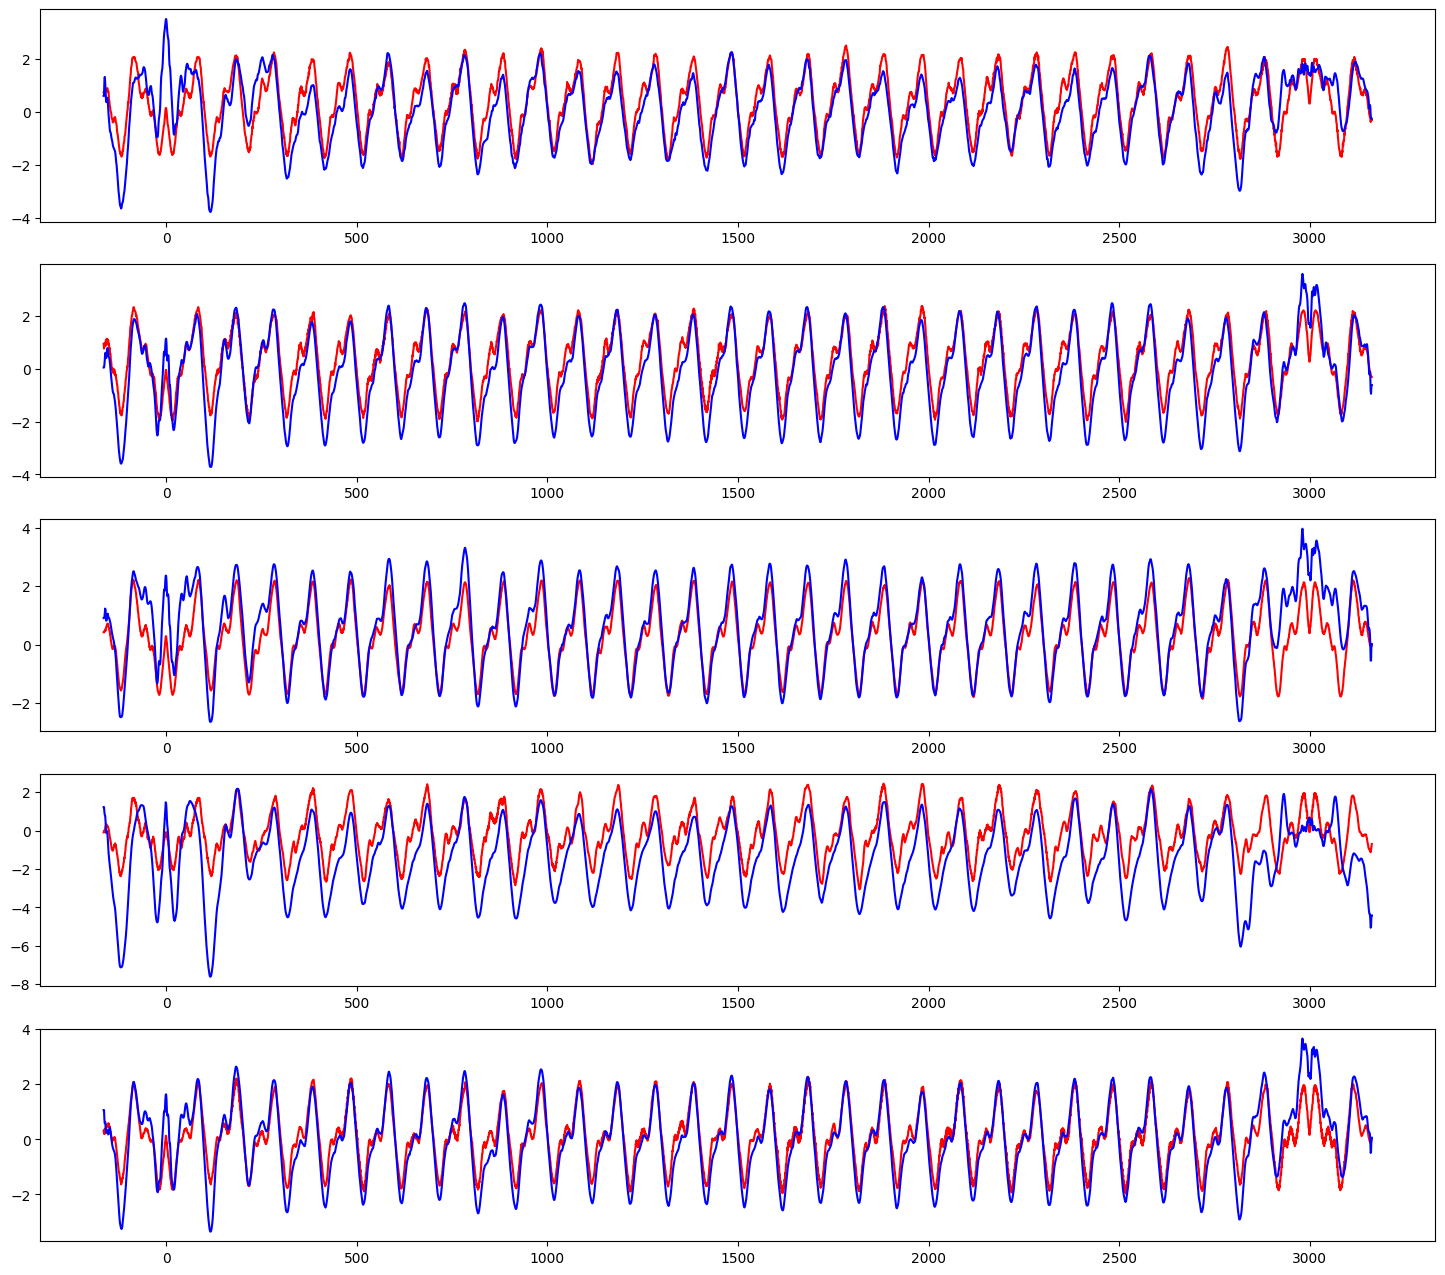

In [19]:
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(18)
for lsel in range(5):
    sdatas = sdata[datal == lsel]

    mean_freq = np.mean(sdatas, axis=0)

    samps = samp[lab == lsel].squeeze()

    mean_freq2 = np.mean(samps, axis=0)

    

    sp1 = fig.add_subplot(5, 1, lsel+1)
    vmax = np.max([np.max(mean_freq), np.max(mean_freq2)])

    plt.plot(vrange,mean_freq, c='r')
    plt.plot(vrange,mean_freq2, c='b')
    # sp1 = fig.add_subplot(1, 2, 2)
    # plt.plot(mean_freq - mean_freq2, c='g')


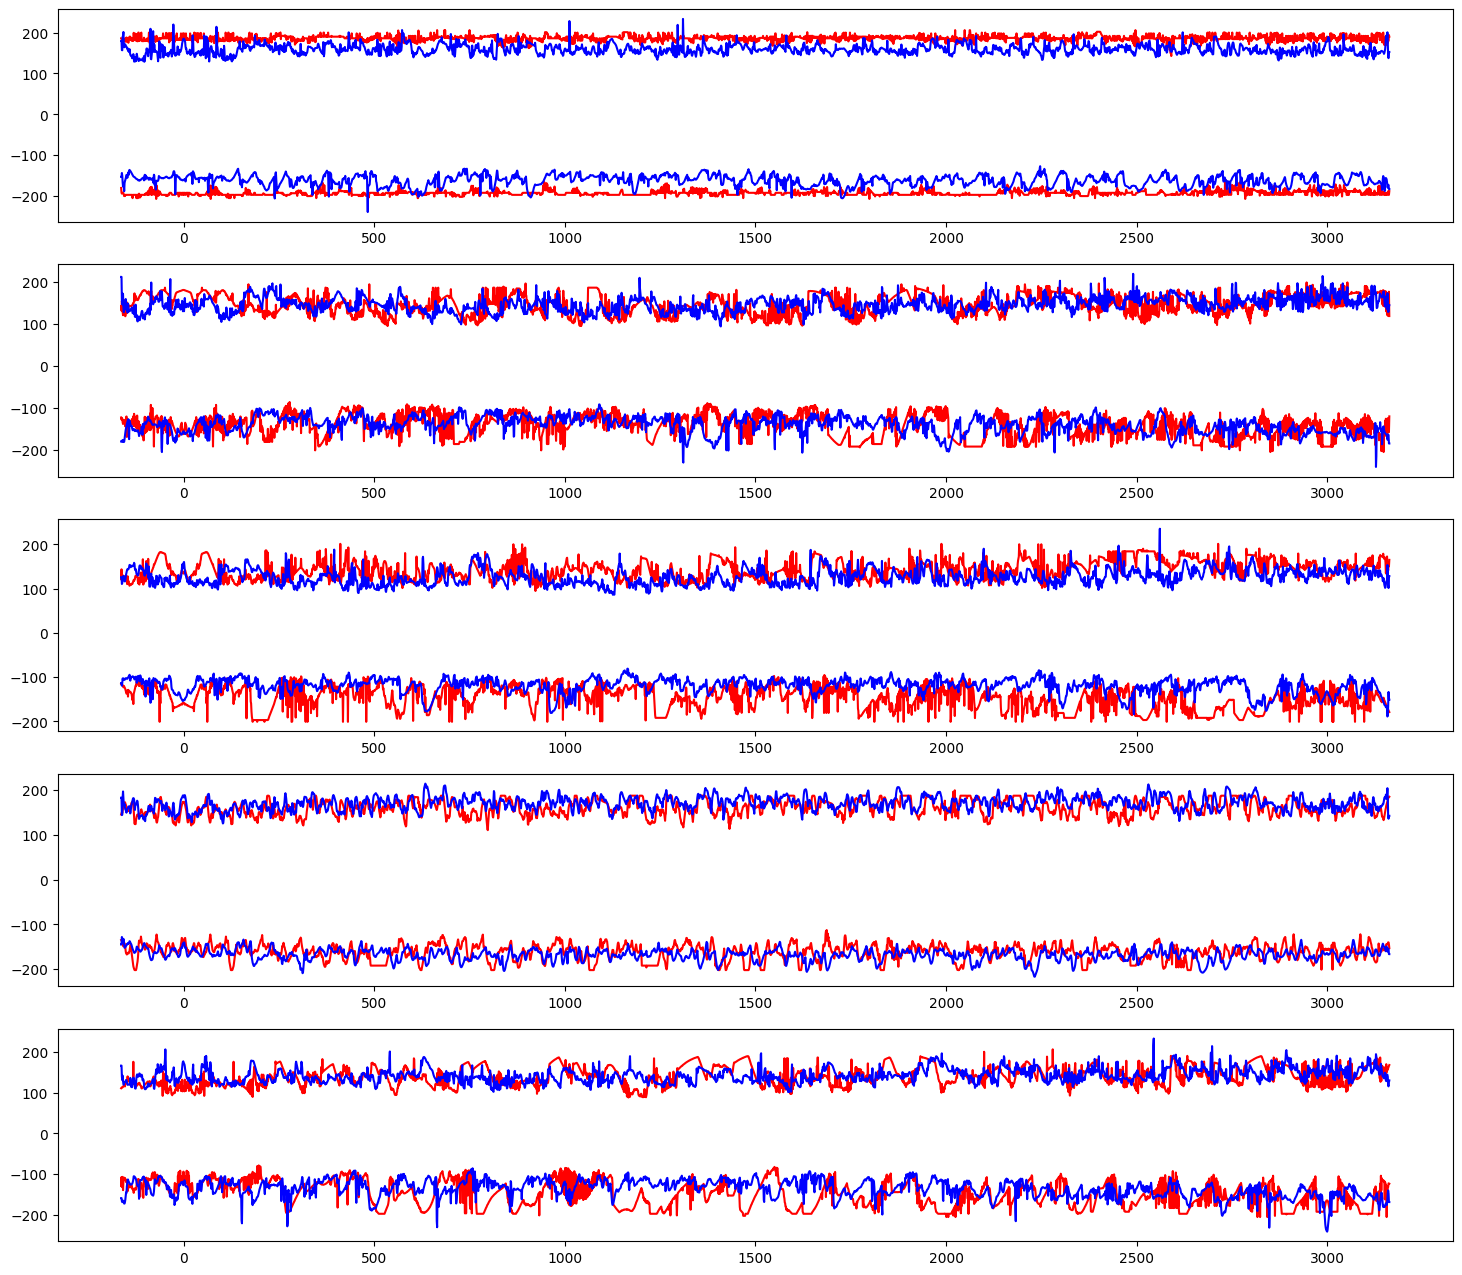

In [20]:
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(18)
for lsel in range(5):
    sdatas = sdata[datal == lsel]

    max_r = np.max(sdatas, axis=0)
    min_r = np.min(sdatas, axis=0)

    samps = samp[lab == lsel].squeeze()

    max_g = np.max(samps, axis=0)
    min_g = np.min(samps, axis=0)
    
    sp1 = fig.add_subplot(5, 1, lsel+1)

    plt.plot(vrange, min_r, c='r')
    plt.plot(vrange,max_r, c='r')
    plt.plot(vrange,min_g, c='b')
    plt.plot(vrange,max_g, c='b')
